In [31]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.simdata_i3 import I3SimBatchHandlerTFRecord
from lib.experimental_methods import get_clean_pulses_fn_v
from lib.network import get_network_eval_v_fn
from lib.charge_network import get_charge_network_eval_v_fn
from lib.geo import cherenkov_cylinder_coordinates_w_rho_v
from lib.geo import get_xyz_from_zenith_azimuth
from lib.cgamma import c_multi_gamma_prob, c_multi_gamma_sf
from lib.plotting import adjust_plot_1d
from lib.trafos import transform_network_inputs_v

from dom_track_eval import get_eval_network_doms_and_track2 as get_eval_network_doms_and_track

import time

dtype = jnp.float32
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco/data/network',
                                       dtype=dtype)
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v, dtype=dtype)

In [32]:
event_id = 10644
tfrecord = f"/home/storage2/hans/i3files/alerts/bfrv2/event_{event_id}_N100_from_0_to_10_1st_pulse.tfrecord"

batch_maker = I3SimBatchHandlerTFRecord(tfrecord, batch_size=100)
batch_iter = batch_maker.get_batch_iterator()

data, mctruth = batch_iter.next()
data = jnp.array(data.numpy())
mctruth = jnp.array(mctruth.numpy())

track_times = mctruth[:, 4]
track_positions = mctruth[:, 5:8]
track_srcs = mctruth[:,2:4]

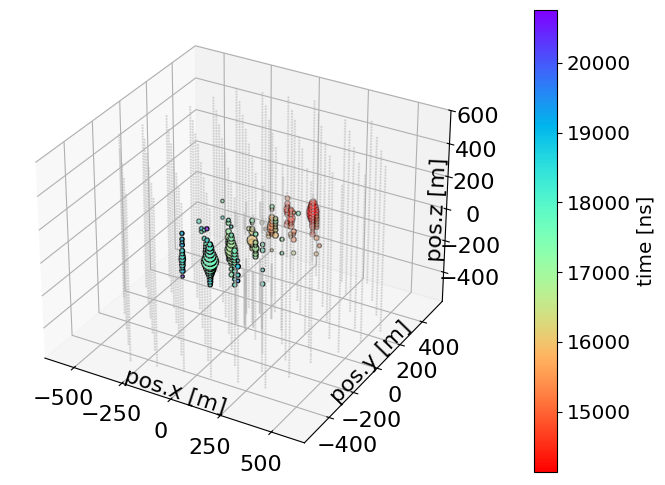

In [166]:
event_idx = 20
event_data = data[event_idx]

geo = pd.read_csv('/home/storage/hans/jax_reco_new/data/icecube/detector_geometry.csv')
df = pd.DataFrame(data=event_data, columns = ["x", "y", "z", "time", "charge"])

def plot_event(df, geo=None):
    fig = plt.figure(figsize=(8,6))
    ax = plt.subplot(projection='3d')
    ax.set_xlabel('pos.x [m]', fontsize=16, labelpad=-25)
    ax.set_ylabel('pos.y [m]', fontsize=16, labelpad=-25)
    ax.set_zlabel('pos.z [m]', fontsize=16, labelpad=-25)

    idx = df['charge'] > 0
    
    try:
        im = ax.scatter(geo['x'], geo['y'], geo['z'], s=0.5, c='0.7', alpha=0.4)
    except:
        pass
    
    im = ax.scatter(df[idx]['x'], df[idx]['y'], df[idx]['z'], s=np.sqrt(df[idx]['charge']*100), c=df[idx]['time'], 
                    cmap='rainbow_r',  edgecolors='k', zorder=1000)
    ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)
    cb = plt.colorbar(im, orientation="vertical", pad=0.1)
    cb.set_label(label='time [ns]', size='x-large')
    cb.ax.tick_params(labelsize='x-large')
        
    plt.show()

plot_event(df, geo)

track_time = track_times[event_idx]
track_pos = track_positions[event_idx]
track_src = track_srcs[event_idx]
track_zenith = track_src[0]
track_azimuth = track_src[1]
track_dir_xyz = get_xyz_from_zenith_azimuth([track_zenith, track_azimuth])

In [167]:
dom_pos = event_data[:, :3]
first_hit_times = event_data[:, 3]
charges = event_data[:, 4]

In [168]:
print(track_src)

[1.93609779 1.68510061]


In [169]:
geo_time, closest_approach_dist, closest_approach_z, closest_approach_rho = \
            cherenkov_cylinder_coordinates_w_rho_v(dom_pos,
                                         track_pos,
                                         track_dir_xyz)
delay_time = first_hit_times - (geo_time + track_time)

In [170]:
eval_charge = get_charge_network_eval_v_fn(bpath='/home/storage/hans/photondata/amplitude_fractions/code/network/tmp2/extract/', n_layer=7)

x = jnp.column_stack([closest_approach_dist,
                          closest_approach_rho,
                          closest_approach_z,
                          jnp.repeat(track_zenith, len(closest_approach_dist)),
                          jnp.repeat(track_azimuth, len(closest_approach_dist))])
x = jnp.array(x, dtype=jnp.float32)
x_prime = transform_network_inputs_v(x)
y_pred = eval_charge(x_prime)

In [171]:
rescale = jnp.sum(charges) / jnp.sum(y_pred) 
q_pred = rescale * y_pred

In [172]:
q_pred = np.squeeze(q_pred)
charges = np.squeeze(charges)
idx = np.argsort(charges[charges>1.e-3]-q_pred[charges>1.e-3])
print((charges[charges>1.e-3]-q_pred[charges>1.e-3])[idx][-10:])
print(charges[charges>1.e-3][idx][-10:])

[ 16.21626346  21.72931039  22.04576943  30.35079703  40.88423379
  42.71135026  43.16117336  49.70067451 110.81849156 156.73724483]
[ 29.25000003  40.62500024  26.42499992  57.17499959  69.47500053
  68.52500033 105.12500036  59.80000019 140.02499932 228.17499986]


(0.1, 1000)

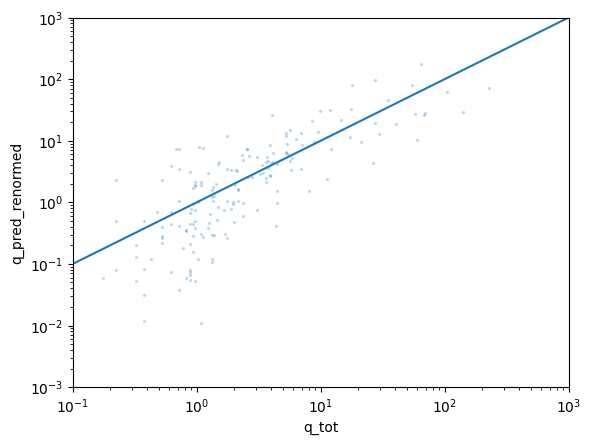

In [173]:
fig, ax = plt.subplots()
plt.scatter(charges[charges>1.e-3], q_pred[charges>1.e-3], s=2, alpha=0.2)
plt.plot([0.001, 1000], [0.001, 1000])
plt.xlabel('q_tot')
plt.ylabel('q_pred_renormed')
plt.yscale('log')
plt.xscale('log')
plt.ylim([0.001, 10**3])
plt.xlim([0.1, 10**3])

In [178]:
print(np.sort(delay_time[charges>1.e-3]))

[-5.07570119e+01  2.29369681e+00  3.05932940e+00  5.05426486e+00
  5.44388709e+00  6.22557725e+00  7.46229436e+00  7.64495780e+00
  8.13437352e+00  9.94676426e+00  1.13328472e+01  1.22157530e+01
  1.66088835e+01  1.66399684e+01  1.99466936e+01  2.03517368e+01
  2.09498361e+01  2.11552889e+01  2.14216939e+01  2.27234206e+01
  2.93482877e+01  3.29655927e+01  4.34027884e+01  4.48322644e+01
  4.82120485e+01  4.84018667e+01  4.85629304e+01  4.88188823e+01
  5.17372555e+01  5.44965272e+01  5.48065622e+01  5.66876952e+01
  5.98974963e+01  6.66122108e+01  6.78594112e+01  7.76486449e+01
  8.67143082e+01  8.70995427e+01  9.02485609e+01  9.36525418e+01
  1.02706430e+02  1.04508444e+02  1.06003402e+02  1.12349408e+02
  1.13584580e+02  1.22305239e+02  1.24854562e+02  1.27548784e+02
  1.29225713e+02  1.29732787e+02  1.34406927e+02  1.35868076e+02
  1.42764968e+02  1.44953295e+02  1.54810536e+02  1.61368275e+02
  1.64739802e+02  1.66772475e+02  1.67597716e+02  1.73607802e+02
  1.77894461e+02  1.84406

In [179]:
print(np.sort(delay_time[charges>1.e-3][np.squeeze(q_pred[charges>1.e-3])<0.01]))

[1068.53296481]


In [180]:
print(np.sort(delay_time[charges>1.e-3][np.squeeze(q_pred[charges>1.e-3])<0.05]))

[ 463.57479305  946.78346517 1068.53296481 1429.24537356 1809.42787548]


In [181]:
print(np.sort(delay_time[charges>1.e-3][np.squeeze(q_pred[charges>1.e-3])<0.1]))

[ -50.75701186  463.57479305  575.32053765  628.9212624   856.3153152
  922.4304063   946.78346517 1044.37820045 1065.21901844 1068.53296481
 1301.68901259 1429.24537356 1809.42787548 1831.51758463 1899.76851507
 2252.35144524]


In [182]:
print(np.sort(delay_time[charges>1.e-3][np.squeeze(q_pred[charges>1.e-3])<0.5]))

[ -50.75701186  104.50844439  320.83568648  438.58058144  438.91019553
  462.25560903  463.57479305  490.92659104  505.33425725  510.68964005
  565.14680238  575.32053765  590.56712942  610.27694832  620.52797219
  625.86617533  628.9212624   654.70262683  809.13578397  846.96309241
  856.3153152   874.27000833  885.18111455  885.80232282  919.34201778
  922.4304063   926.32561859  946.78346517 1032.43502044 1038.45265354
 1044.37820045 1065.21901844 1068.53296481 1107.46237472 1124.10924343
 1187.86565232 1264.17379305 1301.68901259 1335.615405   1429.24537356
 1691.99301949 1721.38437911 1809.42787548 1831.51758463 1899.76851507
 2252.35144524 2778.03830598 2856.75918404 3011.26076697]


In [183]:
print(np.sort(delay_time[charges>1.e-3][np.squeeze(q_pred[charges>1.e-3])<1]))

[ -50.75701186  104.50844439  164.73980186  193.23600507  200.29546388
  301.56708883  320.83568648  329.14363754  388.01456056  403.13134962
  438.21587444  438.58058144  438.91019553  457.93108685  462.25560903
  463.57479305  490.92659104  505.33425725  510.68964005  522.22111399
  565.14680238  575.32053765  590.56712942  610.27694832  620.52797219
  625.86617533  628.9212624   646.22236824  654.70262683  734.09128769
  788.81971057  809.13578397  819.62925187  833.04986946  846.96309241
  856.3153152   874.27000833  885.18111455  885.80232282  888.7931817
  919.34201778  922.4304063   926.32561859  946.78346517 1006.28765718
 1032.43502044 1038.45265354 1044.37820045 1065.21901844 1068.53296481
 1107.46237472 1124.10924343 1187.86565232 1264.17379305 1301.68901259
 1335.615405   1429.24537356 1691.99301949 1721.38437911 1809.42787548
 1831.51758463 1899.76851507 2252.35144524 2778.03830598 2856.75918404
 3011.26076697]
